In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold, train_test_split

RANDOM_STATE = 343

In [4]:
dat = pd.read_csv('healthcare_noshows.csv',
parse_dates=['ScheduledDay', 'AppointmentDay'])

In [5]:
# binary numeric for all binary entries
for column in ['Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up']:
    dat[column] = dat[column]*1

# binary numeric for gender
dat['is_male'] = (dat['Gender']=='M')*1

# extract week day name, covert to dummy binary numeric columns
dow = dat['AppointmentDay'].dt.day_name()
dat = pd.concat([dat, pd.get_dummies(dow, drop_first=True)*1], axis=1)

In [6]:
# flag no shows
# nans are to assist in forward filling
dat['helper'] = dat['Showed_up'].map({0: 1, 1: np.nan})
# sort in chronological order and bring no show information forward
dat = dat.sort_values(by=['PatientId', 'AppointmentDay'])
dat['ever_no_showed'] = dat.groupby('PatientId')['helper'].ffill()
# remaining nans have not previously no showed
dat['ever_no_showed'] = dat['ever_no_showed'].fillna(0.0)

# remove first no show for each patient
# --- see discussion that follows for more detail
# indices of "initial" no shows
idx = dat[dat['helper']==1].groupby('PatientId').head(1).index
# set to 0 because there was no previous no show at time of appointment
dat.loc[idx, 'ever_no_showed'] = 0
# ---

In [7]:
features = [
    'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism',
    'Handcap', 'SMS_received', 'Date.diff', 'is_male', 'ever_no_showed',
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Saturday' # Friday is dropped due to colinearity
]

X = dat[features]
y = dat['Showed_up']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, shuffle=True,
                                                    random_state=RANDOM_STATE, stratify=y)

print('Number of training examples: ', X_train.shape[0])
print('Number of testing examples: ', X_test.shape[0])

Number of training examples:  85589
Number of testing examples:  21398


In [8]:
# center and scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

clfs = {
    'logit': LogisticRegression(),
    'dt': DecisionTreeClassifier(),
    'rf': RandomForestClassifier(),
    'gb': GradientBoostingClassifier(),
    'knn': KNeighborsClassifier()
}

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, clf in clfs.items():
    cv_dict = cross_validate(clf, X_train_scaled, y_train, cv=kf)

    print(name,
          ' test score: \t', np.quantile(cv_dict['test_score'], [.2, .8]),
          '\tfit time: ', np.quantile(cv_dict['fit_time'], [.2, .8]))

logit  test score: 	 [0.79392211 0.79509288] 	fit time:  [0.14523602 0.2354794 ]
dt  test score: 	 [0.72162504 0.72975815] 	fit time:  [0.25323834 0.47167449]
rf  test score: 	 [0.75532216 0.76263582] 	fit time:  [6.78029809 7.83493271]
gb  test score: 	 [0.79975229 0.80061923] 	fit time:  [5.80874243 7.00864477]
knn  test score: 	 [0.76799585 0.77155041] 	fit time:  [0.19692345 0.20598946]


In [12]:
gb = clfs['gb']

param_grid = {
    'max_leaf_nodes': [16, 31, 46],
    'max_depth': [10, 20, 40, 80],
    'min_samples_leaf': [5, 10, 20]
}

from sklearn.model_selection import RandomizedSearchCV

gb_random_clf = RandomizedSearchCV(gb, param_grid, n_iter=10, cv=3,
                                random_state=RANDOM_STATE, n_jobs=-1)

gb_random_clf.fit(X_train_scaled, y_train)
print(gb_random_clf.best_params_)

{'min_samples_leaf': 10, 'max_leaf_nodes': 16, 'max_depth': 80}


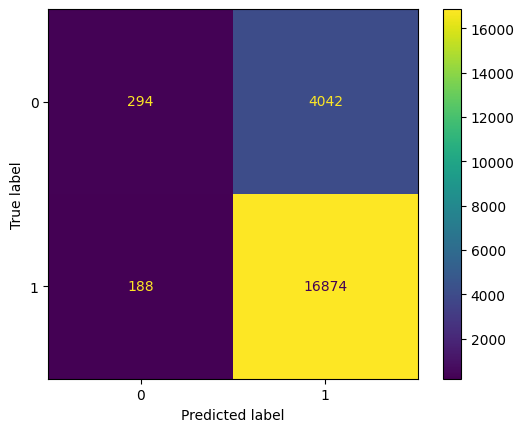

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay.from_estimator(gb_random_clf, X_test_scaled, y_test)

In [14]:
from sklearn.metrics import recall_score, precision_score, f1_score

y_pred = gb_random_clf.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print('test accuracy: \t', round(cm.diagonal().sum()/cm.sum(), 4), '\n')

print('recall score: \t ', round(recall_score(y_test, y_pred), 4))

print('precision score: ', round(precision_score(y_test, y_pred), 4))

print('F1 score: \t', round(f1_score(y_test, y_pred), 4))

test accuracy: 	 0.8023 

recall score: 	  0.989
precision score:  0.8068
F1 score: 	 0.8886


In [15]:
logit = clfs['logit']

param_grid = {
    'C': [.25, .5, 1, 2, 4]
}

from sklearn.model_selection import GridSearchCV

logit_grid_clf = GridSearchCV(logit, param_grid, cv=3, n_jobs=-1)

logit_grid_clf.fit(X_train_scaled, y_train)
print(logit_grid_clf.best_params_)

{'C': 0.25}


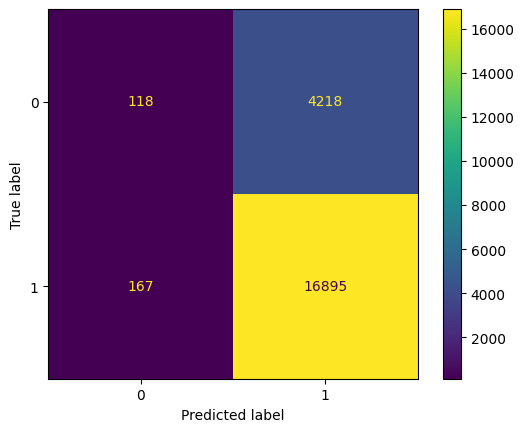

In [16]:
_ = ConfusionMatrixDisplay.from_estimator(logit_grid_clf, X_test_scaled, y_test)

In [17]:
y_pred = logit_grid_clf.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
print('test accuracy: \t', round(cm.diagonal().sum()/cm.sum(), 4), '\n')

print('recall score: \t ', round(recall_score(y_test, y_pred), 4))

print('precision score: ', round(precision_score(y_test, y_pred), 4))

print('F1 score: \t', round(f1_score(y_test, y_pred), 4))

test accuracy: 	 0.7951 

recall score: 	  0.9902
precision score:  0.8002
F1 score: 	 0.8851


In [18]:
# create non-CV classifier with best parameters found, fit
clf = GradientBoostingClassifier()
clf.set_params(**gb_random_clf.best_params_)
clf.fit(X_train_scaled, y_train)

# analyze features
feats = pd.Series(clf.feature_importances_, index=features)
feats.sort_values(ascending=False)

,0
Date.diff,0.694190
Age,0.156655
ever_no_showed,0.070339
SMS_received,0.025703
is_male,0.011345
Scholarship,0.007593
Alcoholism,0.006878
Monday,0.006542
Wednesday,0.004481
Tuesday,0.004313
